# Telco Churn Model

**What we're doing:** We have data on 7,043 telecom customers. Some stayed, some left (churned). We want to build a model that looks at a customer's behaviour and predicts: will this person leave?

**Why it matters:** If we can predict who will leave BEFORE they leave, we can offer them something to stay. That saves the company money because keeping a customer is cheaper than finding a new one.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

## Step 1: Load and look at the data

Always start by understanding what you're working with. How many customers? What columns? What does a row look like?

In [19]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(f"We have {len(df)} customers and {len(df.columns)} columns")
print(f"\nColumns: {list(df.columns)}")
df.head()

We have 7043 customers and 21 columns

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 2: Clean the data

Two things to fix:
1. **TotalCharges** has some blank values (stored as spaces). We convert to numbers and fill blanks with the median.
2. **Churn** is "Yes"/"No" but models need numbers. We convert to 1/0.

In [20]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

print(f"Churn rate: {df['Churn'].mean():.1%}")
print(f"That means {df['Churn'].sum()} out of {len(df)} customers left")

Churn rate: 26.5%
That means 1869 out of 7043 customers left


## Step 3: Explore — who churns and why?

Before building a model, we look at patterns. Three questions:
1. Do new customers churn more than long-term ones?
2. Does contract type matter?
3. Do higher-paying customers churn more?

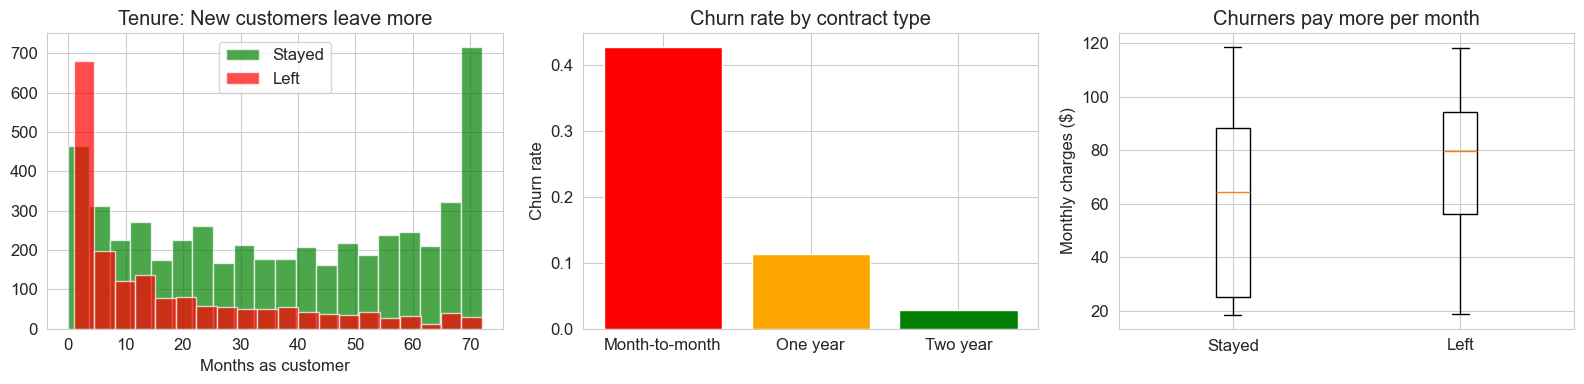

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Question 1: Tenure (how long they've been a customer)
axes[0].hist(df[df["Churn"] == 0]["tenure"], bins=20, alpha=0.7, label="Stayed", color="green")
axes[0].hist(df[df["Churn"] == 1]["tenure"], bins=20, alpha=0.7, label="Left", color="red")
axes[0].set_title("Tenure: New customers leave more")
axes[0].set_xlabel("Months as customer")
axes[0].legend()

# Question 2: Contract type
contract_churn = df.groupby("Contract")["Churn"].mean()
axes[1].bar(contract_churn.index, contract_churn.values, color=["red", "orange", "green"])
axes[1].set_title("Churn rate by contract type")
axes[1].set_ylabel("Churn rate")

# Question 3: Monthly charges
axes[2].boxplot(
    [df[df["Churn"] == 0]["MonthlyCharges"], df[df["Churn"] == 1]["MonthlyCharges"]],
    labels=["Stayed", "Left"]
)
axes[2].set_title("Churners pay more per month")
axes[2].set_ylabel("Monthly charges ($)")

plt.tight_layout()
plt.show()

## Step 4: Prepare features for the model

A model only understands numbers. So we need to:
1. **Pick which columns to use** — we drop customerID (just an ID, no predictive value) and Churn (that's what we're predicting)
2. **Convert text columns to numbers** — "Male"/"Female" becomes 1/0, "Month-to-month"/"One year"/"Two year" becomes separate columns using one-hot encoding
3. **Scale the numbers** — tenure is 0-72, MonthlyCharges is 18-118. Without scaling, the model thinks MonthlyCharges matters more just because the numbers are bigger. Scaling puts everything on the same range.

In [22]:
# X = the information we give the model (features)
# y = the answer we want the model to predict (churn: 1 or 0)

X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"]

# Convert text columns to numbers using one-hot encoding
# Example: Contract has 3 values -> becomes 3 separate columns, each 0 or 1
X = pd.get_dummies(X, drop_first=True)

print(f"Features: {X.shape[1]} columns")
print(f"Target: {len(y)} values ({y.sum()} churned, {(y==0).sum()} stayed)")
X.head()

Features: 30 columns
Target: 7043 values (1869 churned, 5174 stayed)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


## Step 5: Split into training and testing sets

**Why split?** We need to test the model on data it has NEVER seen. If we test on the same data we trained on, it's like giving a student the exam answers and then testing them — of course they'll score well, but they haven't learned anything.

- **Training set (80%)** — the model learns patterns from this
- **Test set (20%)** — we check if the model actually works on this

**stratify=y** means we keep the same churn ratio in both sets. If 26% churned overall, both sets will have ~26% churners.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the numbers so all features are on the same range
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)} customers")
print(f"Testing:  {len(X_test)} customers")
print(f"Training churn rate: {y_train.mean():.1%}")
print(f"Testing churn rate:  {y_test.mean():.1%}")

Training: 5634 customers
Testing:  1409 customers
Training churn rate: 26.5%
Testing churn rate:  26.5%


## Step 6: Train Model 1 — Logistic Regression (the simple one)

**What is Logistic Regression?** It draws a line between churners and non-churners. For each customer it outputs a probability between 0 and 1. A score of 0.8 means "80% chance this customer will churn."

**Why start here?** It's simple, fast, and interpretable. If a simple model works well, you don't need a complex one. It's our **baseline** — the minimum standard the next model must beat.

**class_weight="balanced"** — Our data has 26% churners and 74% non-churners. Without this, the model might just predict "no churn" for everyone and be right 74% of the time — but it would miss every single churner. Setting `balanced` tells the model: "Pay extra attention to the churners, they matter more."

In [24]:
lr_model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# The model now gives each test customer a churn probability
lr_probabilities = lr_model.predict_proba(X_test_scaled)[:, 1]

# Look at some example predictions
examples = pd.DataFrame({
    "Actual": y_test.values[:10],
    "Churn Probability": lr_probabilities[:10].round(3)
})
print("First 10 predictions:")
print(examples.to_string(index=False))

First 10 predictions:
 Actual  Churn Probability
      0              0.117
      0              0.852
      0              0.141
      0              0.665
      0              0.061
      0              0.806
      0              0.700
      0              0.294
      0              0.009
      1              0.652


## Step 7: Evaluate — how good is our model?

### The Confusion Matrix — counting right and wrong predictions

The model gives a probability. To make a yes/no decision, we pick a **threshold** (default 0.5):
- Probability >= 0.5 → predict "will churn"
- Probability < 0.5 → predict "will stay"

Then we count four outcomes:

|  | Predicted: Stay | Predicted: Churn |
|---|---|---|
| **Actually Stayed** | **True Negative (TN)** — Correct! | **False Positive (FP)** — Wrong. We'd waste money offering them something they didn't need |
| **Actually Churned** | **False Negative (FN)** — Wrong. We MISSED a churner. They left and we did nothing | **True Positive (TP)** — Correct! We caught a churner |

From this we get three important numbers:

- **Precision** = TP / (TP + FP) = "Of everyone we flagged as churners, how many actually churned?" High precision = fewer wasted offers
- **Recall** = TP / (TP + FN) = "Of all actual churners, how many did we catch?" High recall = fewer missed churners
- **F1 Score** = the balance between precision and recall. It's their harmonic mean. If either precision OR recall is bad, F1 will be bad too

In [26]:
# Convert probabilities to yes/no predictions using 0.5 threshold
lr_predictions = (lr_probabilities >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, lr_predictions)
print("Confusion Matrix:")
print(f"  True Negatives  (correctly said 'stay'):  {cm[0][0]}")
print(f"  False Positives (wrongly said 'churn'):   {cm[0][1]}")
print(f"  False Negatives (missed churners):        {cm[1][0]}")
print(f"  True Positives  (caught churners):        {cm[1][1]}")

print("\nClassification Report:")
print(classification_report(y_test, lr_predictions, target_names=["Stayed", "Churned"]))

Confusion Matrix:
  True Negatives  (correctly said 'stay'):  749
  False Positives (wrongly said 'churn'):   286
  False Negatives (missed churners):        82
  True Positives  (caught churners):        292

Classification Report:
              precision    recall  f1-score   support

      Stayed       0.90      0.72      0.80      1035
     Churned       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



### AUC-ROC — how well does the model RANK customers?

**The problem with a single threshold:** Using 0.5 as the cutoff is arbitrary. What if 0.3 works better? What if 0.7?

**ROC Curve** answers: "How well does the model separate churners from non-churners across ALL possible thresholds?"

It plots:
- **X-axis: False Positive Rate** — what % of non-churners are we wrongly flagging?
- **Y-axis: True Positive Rate (Recall)** — what % of actual churners are we catching?

A perfect model hugs the top-left corner. A random guess is the diagonal line.

**AUC = Area Under the Curve** — a single number between 0 and 1:
- **1.0** = perfect model (catches every churner, never flags a non-churner)
- **0.5** = random coin flip (useless)
- **0.8+** = good model

**Why AUC matters more than accuracy:** In the interview, if they ask "why not just use accuracy?" — say: "Because with 74% non-churners, a model that predicts 'stay' for everyone gets 74% accuracy but catches zero churners. AUC measures ranking quality regardless of the threshold."

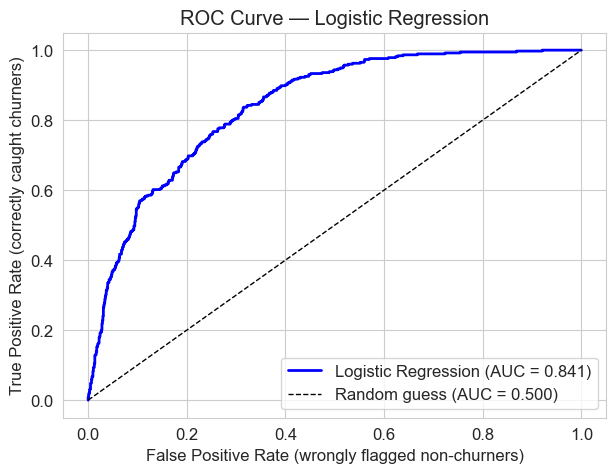

AUC-ROC: 0.841
This means the model ranks a random churner above a random non-churner 84% of the time


In [27]:
lr_auc = roc_auc_score(y_test, lr_probabilities)

fpr, tpr, thresholds = roc_curve(y_test, lr_probabilities)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"Logistic Regression (AUC = {lr_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random guess (AUC = 0.500)")
plt.xlabel("False Positive Rate (wrongly flagged non-churners)")
plt.ylabel("True Positive Rate (correctly caught churners)")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.show()

print(f"AUC-ROC: {lr_auc:.3f}")
print(f"This means the model ranks a random churner above a random non-churner {lr_auc:.0%} of the time")

## Step 8: Train Model 2 — XGBoost (the powerful one)

**What is XGBoost?** It builds many small decision trees, one after another. Each new tree focuses on the mistakes the previous trees made. It's like a team of weak students who each learn from the previous student's errors — together they become strong.

**Why use it?** Logistic Regression draws a straight line. But real patterns aren't always straight. XGBoost captures complex patterns like: "customers who have month-to-month contracts AND are new AND pay a lot — those churn the most." It finds combinations that Logistic Regression can't.

**scale_pos_weight** does the same job as `class_weight="balanced"` — it tells XGBoost to pay more attention to churners.

In [28]:
# Ratio of non-churners to churners (about 2.7 to 1)
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=imbalance_ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric="auc"
)

xgb_model.fit(X_train_scaled, y_train)

xgb_probabilities = xgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_predictions = (xgb_probabilities >= 0.5).astype(int)
xgb_auc = roc_auc_score(y_test, xgb_probabilities)

print(f"Logistic Regression AUC: {lr_auc:.3f}")
print(f"XGBoost AUC:             {xgb_auc:.3f}")
print(f"Improvement:             {xgb_auc - lr_auc:+.3f}")
print(f"\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions, target_names=["Stayed", "Churned"]))

Logistic Regression AUC: 0.841
XGBoost AUC:             0.842
Improvement:             +0.001

XGBoost Classification Report:
              precision    recall  f1-score   support

      Stayed       0.91      0.74      0.81      1035
     Churned       0.52      0.80      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.77      1409



## Step 9: What features matter most?

This answers the interview question: "What drives churn?" The model tells us which features had the most influence on its predictions.

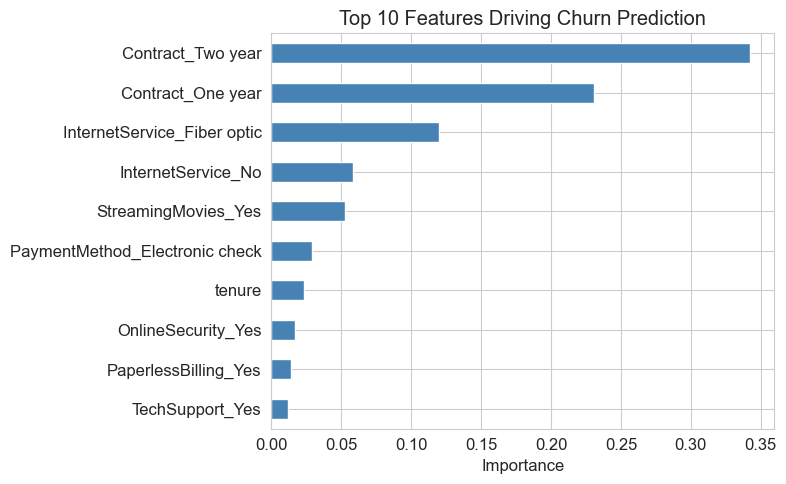

In [29]:
importance = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_10 = importance.sort_values(ascending=True).tail(10)

plt.figure(figsize=(8, 5))
top_10.plot(kind="barh", color="steelblue")
plt.title("Top 10 Features Driving Churn Prediction")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Step 10: Segmentation — who gets what offer?

### What is segmentation?

**Segmentation** means dividing customers into groups so you can treat each group differently.

Think of it like a hospital triage:
- A patient with a broken finger and a patient with a heart attack both need help
- But you don't give them the same treatment, and you don't treat them with the same urgency

Same with churn:
- A customer who spends $100/month and is about to leave → give them your best retention offer (they're worth saving)
- A customer who spends $20/month and is about to leave → send them a text message at most (not worth an expensive offer)
- A customer who spends $100/month and is happy → don't waste a retention offer on them (they're not leaving)

We create a **2x2 matrix** using:
1. **Risk** — how likely are they to churn? (from the model's probability score)
2. **Value** — how much do they spend? (from their MonthlyCharges)

In [30]:
# Score every customer
df["churn_score"] = xgb_model.predict_proba(scaler.transform(pd.get_dummies(df.drop(columns=["customerID", "Churn"]), drop_first=True)))[:, 1]

# Divide into risk groups
df["risk"] = "Low Risk"
df.loc[df["churn_score"] >= 0.5, "risk"] = "High Risk"

# Divide into value groups
median_spend = df["MonthlyCharges"].median()
df["value"] = "Low Value"
df.loc[df["MonthlyCharges"] >= median_spend, "value"] = "High Value"

# Create segment
df["segment"] = df["risk"] + " + " + df["value"]

# Count customers in each segment
segment_table = df.groupby("segment").agg(
    customers=("customerID", "count"),
    avg_churn_score=("churn_score", "mean"),
    avg_monthly_spend=("MonthlyCharges", "mean"),
    actual_churn_rate=("Churn", "mean")
).round(3)

print("Customer Segments:")
print(segment_table)
print(f"\nMedian monthly spend (split point): ${median_spend:.0f}")

Customer Segments:
                        customers  avg_churn_score  avg_monthly_spend  \
segment                                                                 
High Risk + High Value       1929            0.751             89.114   
High Risk + Low Value         919            0.692             45.835   
Low Risk + High Value        1595            0.205             92.326   
Low Risk + Low Value         2600            0.154             36.474   

                        actual_churn_rate  
segment                                    
High Risk + High Value              0.584  
High Risk + Low Value               0.507  
Low Risk + High Value               0.070  
Low Risk + Low Value                0.063  

Median monthly spend (split point): $70


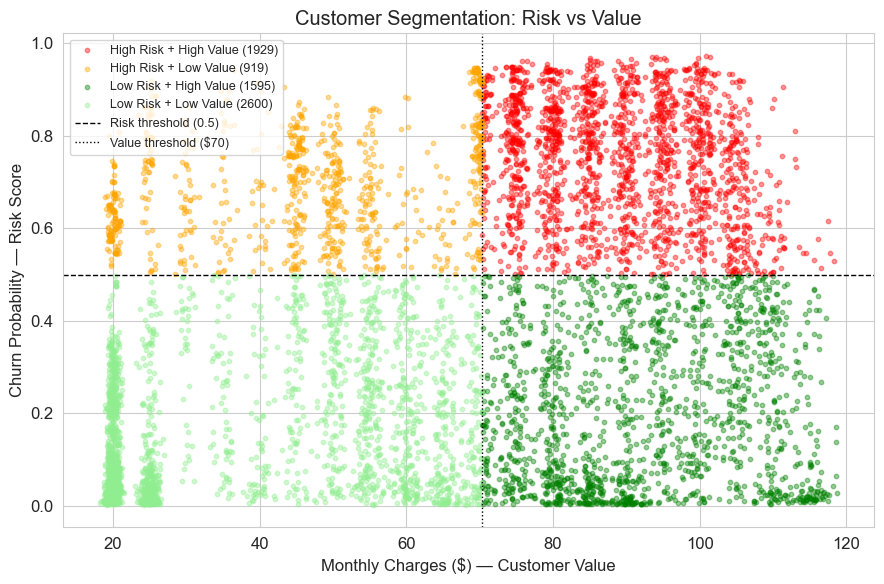

In [31]:
# Visualise: scatter plot of all customers by risk and value
plt.figure(figsize=(9, 6))

colors = {
    "High Risk + High Value": "red",
    "High Risk + Low Value": "orange",
    "Low Risk + High Value": "green",
    "Low Risk + Low Value": "lightgreen"
}

for segment, color in colors.items():
    mask = df["segment"] == segment
    plt.scatter(
        df[mask]["MonthlyCharges"],
        df[mask]["churn_score"],
        c=color, label=f"{segment} ({mask.sum()})", alpha=0.4, s=10
    )

plt.axhline(y=0.5, color="black", linestyle="--", lw=1, label="Risk threshold (0.5)")
plt.axvline(x=median_spend, color="black", linestyle=":", lw=1, label=f"Value threshold (${median_spend:.0f})")
plt.xlabel("Monthly Charges ($) — Customer Value")
plt.ylabel("Churn Probability — Risk Score")
plt.title("Customer Segmentation: Risk vs Value")
plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

## Step 11: Business recommendations — what we'd actually DO

This is the part that matters in the interview. The model is just a tool. What matters is the **decision** it enables.

In [32]:
OFFER_COST = 30       # cost of a retention offer per customer
CUSTOMER_VALUE = 200  # average value of keeping a customer for 90 days
SAVE_RATE = 0.40      # 40% of offered customers actually stay

for segment in ["High Risk + High Value", "High Risk + Low Value", "Low Risk + High Value", "Low Risk + Low Value"]:
    seg = df[df["segment"] == segment]
    n = len(seg)
    churners = seg["Churn"].sum()

    if "High Risk" in segment:
        saved = int(churners * SAVE_RATE)
        cost = n * OFFER_COST
        revenue = saved * CUSTOMER_VALUE
        profit = revenue - cost

        print(f"\n{segment}: {n} customers, {churners} would churn")
        print(f"  If we offer all of them a ${OFFER_COST} retention deal:")
        print(f"  Cost:    ${cost:,}")
        print(f"  Saved:   {saved} customers")
        print(f"  Revenue: ${revenue:,}")
        print(f"  Profit:  ${profit:,} {'(worth it!)' if profit > 0 else '(not worth it)'}")
    else:
        print(f"\n{segment}: {n} customers, {churners} would churn")
        print(f"  Action: No retention offer needed (low risk)")

print("\n" + "="*60)
print("KEY INSIGHT: We only spend money on high-risk customers.")
print("The model tells us WHO to spend on, so we don't waste money")
print("on customers who would have stayed anyway.")


High Risk + High Value: 1929 customers, 1126 would churn
  If we offer all of them a $30 retention deal:
  Cost:    $57,870
  Saved:   450 customers
  Revenue: $90,000
  Profit:  $32,130 (worth it!)

High Risk + Low Value: 919 customers, 466 would churn
  If we offer all of them a $30 retention deal:
  Cost:    $27,570
  Saved:   186 customers
  Revenue: $37,200
  Profit:  $9,630 (worth it!)

Low Risk + High Value: 1595 customers, 112 would churn
  Action: No retention offer needed (low risk)

Low Risk + Low Value: 2600 customers, 165 would churn
  Action: No retention offer needed (low risk)

KEY INSIGHT: We only spend money on high-risk customers.
The model tells us WHO to spend on, so we don't waste money
on customers who would have stayed anyway.


## Summary — what to say in the interview

**"What did you build?"**
A churn prediction model that scores every customer on their likelihood to leave, then segments them by risk and value to recommend who gets a retention offer and who doesn't.

**"Why not just use accuracy?"**
Because accuracy rewards predicting the majority class. A model that says "nobody will churn" gets 74% accuracy but catches zero churners. AUC-ROC measures how well the model ranks customers, regardless of the threshold.

**"What is F1?"**
The balance between precision (are my flags accurate?) and recall (did I catch most churners?). If either is bad, F1 is bad.

**"What is segmentation?"**
Dividing customers into groups based on risk and value, so we give expensive offers to high-value customers at risk, cheap nudges to low-value ones at risk, and nothing to customers who are fine.

**"How do you prove it works?"**
Hold out 10% of high-risk customers as a control group — they get no offer. After 90 days, compare churn rates. The difference is the incremental lift — the true value the model created.